# Behavior Cloning

Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning). 

The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning. 

In [1]:
# The following lines are needed when using Windows 
# An error regarding this happens when the program is trying to initialize multiple versions of the libiomp5md.dll library (the Intel OpenMP runtime), which leads to conflicts. 
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
sys.path.append("C:\\Users\\sc3377\\Documents\\balloon-outreach")

In [2]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from exp.learning_util import plot_agent_trajectory

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [3]:
import xarray as xr

ds          = xr.open_dataset("C:\\Users\\sc3377\\Documents\\balloon-outreach\\era5_data.nc", engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)

#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0
target_lat = 47
target_lon = -78
target_alt = 12.0
time_step = 120 #120 seconds
max_steps = int(1440/(time_step/60)) #1 day
noise_std = 0.1
horizon=10
num_samples=10
num_iterations=1
env = BalloonERAEnvironment(ds=ds, 
                            start_time=start_time, 
                            initial_lat=initial_lat, 
                            initial_lon=initial_lon, 
                            initial_alt=initial_alt, 
                            target_lat=target_lat, 
                            target_lon=target_lon,
                            target_alt=target_alt, 
                            dt=time_step,
                            viz=False)

In [4]:
env.wind_field.disable_noise()
initial_state = env.reset()
print(initial_state) # 21-dimensional vector

# state = (latitude, longitude, altitude, volume/max_volume, sand/max_sand, 
# vertical velocity, current_time, uv vectors in 7 different pressure levels)

[ 42.6        -76.5         10.           1.           1.
   0.           0.           2.68826294  -2.50693054  11.1584198
  -7.97099304  14.01635132  -5.00876465  27.14085999   3.41699524
  34.82033386  14.09255371  38.58664856   7.6340332   18.78843994
  -4.25058899]


## Define expert policy and collect expert state-action pair

In [5]:
expert = MPPIAgentWithCostFunction(target_lat=target_lat, 
                                  target_lon=target_lon, 
                                  target_alt=target_alt, 
                                  num_samples=num_samples, 
                                  noise_std=noise_std, 
                                  num_iterations=num_iterations, 
                                  horizon=horizon, 
                                  objective='target')

In [6]:
# Run an episode from an expert and collect its behavior

def run_expert_episode(
        env: BalloonERAEnvironment, 
        agent:MPPIAgent, 
        max_steps: int = 100,
        policy_name: str='expert'):
    """
    Run one episode with the given agent,
    collect state-action pair of the agent,
    and plot its trajectory in the given environment.
    """
    # Save state-action pairs from expert policy
    initial_states = []
    initial_actions = []

    state = env.reset()
    total_reward = 0
    
    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []
    for step in range(max_steps):
        # Get action from agent
        action = agent.select_action(state, env, step)
        
        # record state and expert action
        initial_states.append(state)
        initial_actions.append(action)
        
        # Take step
        state, reward, done, info = env.step(action)
        total_reward += reward
        
        actions.append(float(action[0]) if isinstance(action, np.ndarray) else float(action))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])
        print(f"Step {step}: lat: {state[0]:.2f}, lon: {state[1]:.2f}, alt: {state[2]:.2f}")
        # env.render()
        
        if done:
            print(f"\nEpisode terminated: {info}")
            break   

    # Convert to arrays
    states_np = np.array(initial_states, dtype=np.float32)
    actions_np = np.array(initial_actions, dtype=np.float32)
    print(f"Collected {len(initial_states)} state-action pairs from expert.")

    # Plot final trajectory
    plot_agent_trajectory(trajectory=trajectory,
                          altitudes=altitudes,
                          actions=actions,
                          velocities=velocities,
                          helium_mass=helium_mass,
                          sands=sands,
                          policy_name=policy_name,
                          max_steps=max_steps,
                          dt=env.dt,
                          objective=agent.objective,
                          target_lon=env.target_lon,
                          target_lat=env.target_lat,
                          target_alt=env.target_alt
                          )

    return total_reward, states_np, actions_np

In [ ]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np = run_expert_episode(env, expert, max_steps=max_steps, policy_name=f'expert_noiseless_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)

Step 0: lat: 42.61, lon: -76.50, alt: 10.00
Step 1: lat: 42.62, lon: -76.50, alt: 10.01
Step 2: lat: 42.63, lon: -76.51, alt: 10.02
Step 3: lat: 42.64, lon: -76.51, alt: 10.04
Step 4: lat: 42.65, lon: -76.51, alt: 10.08
Step 5: lat: 42.66, lon: -76.51, alt: 10.12
Step 6: lat: 42.67, lon: -76.51, alt: 10.17
Step 7: lat: 42.68, lon: -76.52, alt: 10.23
Step 8: lat: 42.69, lon: -76.52, alt: 10.30
Step 9: lat: 42.70, lon: -76.52, alt: 10.38
Step 10: lat: 42.71, lon: -76.52, alt: 10.47
Step 11: lat: 42.72, lon: -76.52, alt: 10.56
Step 12: lat: 42.73, lon: -76.53, alt: 10.66
Step 13: lat: 42.74, lon: -76.53, alt: 10.77
Step 14: lat: 42.75, lon: -76.53, alt: 10.88
Step 15: lat: 42.77, lon: -76.53, alt: 11.00
Step 16: lat: 42.78, lon: -76.53, alt: 11.12
Step 17: lat: 42.79, lon: -76.53, alt: 11.24
Step 18: lat: 42.80, lon: -76.54, alt: 11.35
Step 19: lat: 42.81, lon: -76.54, alt: 11.47
Step 20: lat: 42.82, lon: -76.54, alt: 11.59
Step 21: lat: 42.83, lon: -76.54, alt: 11.70
Step 22: lat: 42.85,

In [8]:
print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

[np.float64(-1191.9683153868204), np.float64(-1191.9520467122823), np.float64(-1191.8807514867901)]
Expert Trajectory reward in average: -1191.93


In [9]:
expert_states_np = np.concatenate(expert_states_list)
expert_actions_np = np.concatenate(expert_actions_list)

## Define our policy network

In [10]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [11]:
# Evaluate a policy on the environment
def evaluate_policy(env: BalloonERAEnvironment, 
                    policy: nn.Module,
                    max_steps: int,
                    policy_name: str,
                    expert_avg_total_reward: float):
    policy.eval()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    state = env.reset()
    total_reward = 0.0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []

    for step in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)      # shape (1, 21)
        action_pred = policy(state_tensor).item()                        # continuous action
        state, reward, done, info = env.step(action_pred)
        total_reward += reward

        actions.append(float(action_pred) if isinstance(action_pred, np.ndarray) else float(action_pred))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])

        if done:
            print(f"\nEpisode terminated: {info}")
            break
    print(f"Total reward obtained from current policy: {total_reward:.2f}")
    print(f"Expert policy reward - Current policy reward: {expert_avg_total_reward-total_reward:.2f}")

    # Plot final trajectory
    plot_agent_trajectory(trajectory=trajectory,
                          altitudes=altitudes,
                          actions=actions,
                          velocities=velocities,
                          helium_mass=helium_mass,
                          sands=sands,
                          policy_name=policy_name,
                          max_steps=max_steps,
                          dt=env.dt,
                          objective='target',
                          target_lon=env.target_lon,
                          target_lat=env.target_lat,
                          target_alt=env.target_alt
                          )

    return total_reward

In [12]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
evaluate_policy(env, policy, max_steps=max_steps, policy_name='random_policy_noiseless_wf', expert_avg_total_reward=expert_avg_total_reward)

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1196.58
Expert policy reward - Current policy reward: 4.65


np.float64(-1196.581317496435)

## Behavior Cloning (Supervised Learning)

In [13]:
# === Initial Dataset & DataLoader Construction ===

# Convert to tensors
states_tensor = torch.from_numpy(expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [14]:
# === Training Function Using Loader ===
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")
        
    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/10 — Avg Loss: 0.081692 

→ policy is in training mode
Epoch 2/10 — Avg Loss: 0.026517 

→ policy is in training mode
Epoch 3/10 — Avg Loss: 0.022540 

→ policy is in training mode
Epoch 4/10 — Avg Loss: 0.020783 

→ policy is in training mode
Epoch 5/10 — Avg Loss: 0.018554 

→ policy is in training mode
Epoch 6/10 — Avg Loss: 0.017720 

→ policy is in training mode
Epoch 7/10 — Avg Loss: 0.015859 

→ policy is in training mode
Epoch 8/10 — Avg Loss: 0.014261 

→ policy is in training mode
Epoch 9/10 — Avg Loss: 0.013670 

→ policy is in training mode
Epoch 10/10 — Avg Loss: 0.015679 



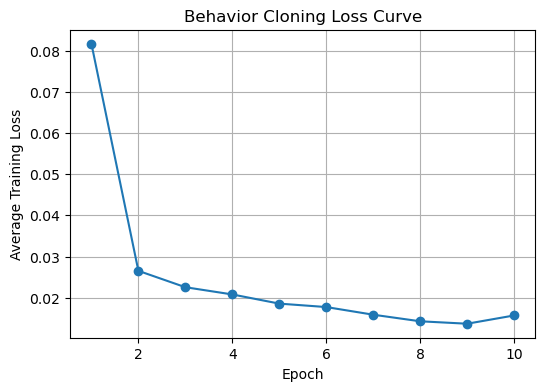

In [15]:
losses = []
for epoch in range(10):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/10 — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from behavior cloning
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

In [16]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10)
evaluate_policy(env, policy, max_steps=max_steps, policy_name='BC_trained_policy_noiseless_wf', expert_avg_total_reward=expert_avg_total_reward)

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: -1192.98
Expert policy reward - Current policy reward: 1.04


np.float64(-1192.9763296672133)